<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/model_architecture_experiments/(Custom_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf /content/data_13
!cp -r /content/drive/MyDrive/Objectdetection/data_13 /content

In [3]:
!rm -rf /content/data_13/.ipynb_checkpoints
!rm -rf /content/data_13/test/.ipynb_checkpoints
!rm -rf /content/data_13/train/.ipynb_checkpoints

In [1]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
num_classes=5
model.rpn.anchor_generator = AnchorGenerator(sizes=((8,16,32,64),),
                                   aspect_ratios=((0.25,0.5,1.0,2.0),))
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True).backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): FrozenBatchNorm2d(16, eps=1e-05)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): FrozenBatchNorm2d(16, eps=1e-05)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(16, eps=1e-05)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(64, eps=1e-05)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActiva

In [31]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

backbone = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True).backbone
backbone.out_channels=256

sizes = ((8, 16, 32, 64),) 
aspect_ratios = ((0.25, 0.5, 1.0, 2.0),) 
num_feature_maps = 3

sizes *= num_feature_maps
aspect_ratios *= num_feature_maps

anchor_generator = AnchorGenerator(sizes=sizes, aspect_ratios=aspect_ratios)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0', '1', '3'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(backbone,
                   num_classes=5,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [32]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = CityDataset('/content/data_13/train', get_transform(train=True))
dataset_test = CityDataset('/content/data_13/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params_backbone = [param for name,param in model.named_parameters() if param.requires_grad and 'backbone' in name ]
params_other = [param for name,param in model.named_parameters() if param.requires_grad and 'backbone' not in name]

optimizer = torch.optim.SGD([
                {'params': params_backbone, 'lr':1e-1},
                {'params': params_other}
            ], lr=2e-1, momentum=0.09,weight_decay=0.000005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

num_epochs = 30

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/16]  eta: 0:00:16  lr: 0.006760  loss: 2.8684 (2.8684)  loss_classifier: 1.7108 (1.7108)  loss_box_reg: 0.0324 (0.0324)  loss_objectness: 0.6915 (0.6915)  loss_rpn_box_reg: 0.4336 (0.4336)  time: 1.0455  data: 0.3941  max mem: 7002
Epoch: [0]  [10/16]  eta: 0:00:02  lr: 0.073360  loss: 1.6468 (1.8418)  loss_classifier: 0.3111 (0.6040)  loss_box_reg: 0.1024 (0.1104)  loss_objectness: 0.6715 (0.6456)  loss_rpn_box_reg: 0.4336 (0.4818)  time: 0.4714  data: 0.0610  max mem: 7119
Epoch: [0]  [15/16]  eta: 0:00:00  lr: 0.100000  loss: 1.5935 (1.6961)  loss_classifier: 0.3181 (0.5261)  loss_box_reg: 0.1154 (0.1259)  loss_objectness: 0.6107 (0.5866)  loss_rpn_box_reg: 0.3798 (0.4575)  time: 0.4429  data: 0.0493  max mem: 7119
Epoch: [0] Total time: 0:00:07 (0.4502 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.0769 (0.0769)  evaluator_time: 0.0280 (0.0280)  time: 0.3975  data: 0.2886  max mem: 7119
Test:  [3/4]  eta: 0:00:00  model_time: 0.07

In [34]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    print(scores)
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 512, 512])
[0.9859436750411987, 0.984265923500061, 0.9834416508674622, 0.9770590662956238, 0.9755399823188782, 0.9671109318733215, 0.9640918970108032, 0.9486952424049377, 0.9310740828514099, 0.9119581580162048, 0.9092342853546143, 0.8517712950706482, 0.8361070156097412, 0.8192750215530396, 0.8192505836486816, 0.7647055387496948, 0.7635656595230103, 0.7620846033096313, 0.7349280714988708, 0.7290617823600769, 0.7218313217163086, 0.7212855219841003, 0.6989715099334717, 0.6975229978561401, 0.6885473132133484, 0.6564894318580627, 0.6230917572975159, 0.5906827449798584, 0.5452505350112915, 0.5380918979644775, 0.5348078608512878, 0.5312819480895996, 0.5139285326004028, 0.4757634699344635, 0.42479977011680603, 0.37668293714523315, 0.36667951941490173, 0.33775442838668823, 0.33014437556266785, 0.32903429865837097, 0.3207617998123169, 0.3047736883163452, 0.2900475263595581, 0.27796706557273865, 0.2704835534095764, 0.25048699975013733, 0.24762561917304993, 0.2452666461467743, 0.244

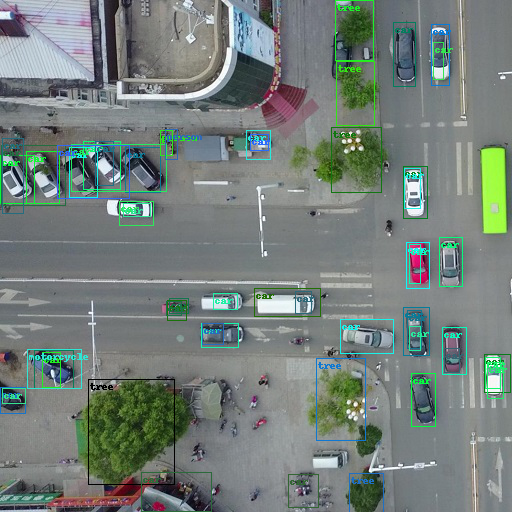

In [40]:
img, time_taken = get_inference('/content/test2.jpg', 0.2, model)
print(time_taken)
img.show()

In [ ]:
# torch.save(model.state_dict(), '/content/model_best_current.pt')
# !cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model_best_current.pt'))
model1.to(device)
model1.eval()